# Advanced Model: Prophet (by Meta)
This notebook builds and evaluates a Prophet model to forecast Bitcoin transaction fees over the next 24 hours, based on 15-minute interval data from the mempool dataset.

### Why Prophet?

During exploratory data analysis (EDA), we observed:

- Clear daily and weekly seasonality in fee patterns,

- Sudden spikes in fees due to network congestion (potential "holidays"),

- Multiple changepoints, indicating regime shifts or structural breaks.

The Prophet model is well-suited for this context because it:

- Handles nonlinear trends with automatic changepoint detection,

- Supports multiple seasonalities (daily, weekly, and custom),

- Allows incorporation of holiday effects (e.g., congestion spikes),

- Is robust to missing data and outliers.

This notebook demonstrates the full modeling process using Prophet, including customization of seasonalities and holidays.

### Why This Step Matters
- Ensures model choice is grounded in EDA and domain knowledge

- Justifies Prophet as a flexible yet interpretable time series model

- Helps guide configuration toward realistic and meaningful forecasting setup



### Import required libraries

In [30]:
import numpy as np
from prophet.serialize import model_from_json
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
import sys
sys.path.append("../src/")
from preprocess_raw_parquet import preprocess_raw_parquet
from plot_series import plot_series
from custom_loss_eval import eval_metrics
sys.path.append("../scripts/prophet")
from prophet_utils import create_model_new_holiday,evaluate_model,create_model_new

### Why This Step Matters
- Sets up tools for modeling, data handling, and visualization

- Ensures reproducibility and modularity of the workflow



### Load data

We begin with loading the preprocessed dataset specifically prepared for Prophet models.

In [32]:
df_new = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df_new.dropna(inplace = True)
df_new.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Why This Step Matters
- Ensures consistency in data types and structure (ds, y) required by Prophet

- Preprocessing removes noise and prepares a clean input for trend and seasonality modeling

### Split train and test data
Recommanded fastest fee rate is our target. Here we choose the last 24-hour data as the test data and the others as training data. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [33]:
df_new = df_new.iloc[:-96]
y_new = df_new["recommended_fee_fastestFee"]
X_new = df_new.drop(columns = "recommended_fee_fastestFee")
X_new = X_new.reset_index()
X_new = X_new.drop(columns = "timestamp")

# last 24h as test
split_index = len(X_new) - 96

X_train_new, X_test_new = X_new.iloc[:split_index], X_new.iloc[split_index:]
y_train_new, y_test_new = y_new.iloc[:split_index], y_new.iloc[split_index:]


### Why This Step Matters
- Mimics real-world scenario: forecast next day from known history

- Avoids leakage from future data into training

- Prevents spike-influenced overfitting and yields more generalizable performance

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [34]:
df_prophet_new = y_train_new.reset_index()
df_prophet_new = df_prophet_new.rename(columns={
    'timestamp': 'ds',
    'recommended_fee_fastestFee': 'y'
})
df_prophet_new['y'] = np.log1p(df_prophet_new['y'])
df_prophet_new.head()

,ds,y
0,2025-03-05 02:00:00,1.098612
1,2025-03-05 02:15:00,1.386294
2,2025-03-05 02:30:00,1.098612
3,2025-03-05 02:45:00,1.203973
4,2025-03-05 03:00:00,1.466337


### Optimization - Find the best params

We choose GridSearch to optimize the model. Here are the ranges of parameters.

changepoint_prior_scale controls the model’s flexibility to adapt to changes in trend. A smaller value makes the trend smoother (less sensitive to abrupt changes), while a larger value allows more flexibility.

seasonality_prior_scale adjusts the strength of the seasonal components. Higher values allow more complex seasonal patterns, which is useful if the data shows strong seasonality.

seasonality_mode can be 'additive' or 'multiplicative', depending on whether seasonal effects are constant or scale with the level of the series. Since fee levels can change dramatically, it's important to compare both.

changepoint_range defines the portion of the historical data in which Prophet will look for potential changepoints. We test different values to balance early and recent trend shifts.

n_changepoints sets how many potential changepoints the model should consider. More changepoints allow better flexibility but can risk overfitting.

Our base Prophet model is constructed with:

- No automatic daily or weekly seasonality, because we explicitly add customized seasonality components based on domain knowledge.

- A custom hourly seasonality (period=1/24) to capture intraday fee fluctuations, which are prominent in high-frequency transaction data.

- A daily seasonality to model repeated daily behavior (e.g., daytime congestion).

- A weekly seasonality to reflect usage patterns across different days of the week.

This structured setup allows fine control over periodic patterns, avoids overfitting from default assumptions, and better reflects the temporal structure of transaction fee data at 15-minute intervals.

The optimizing process will not be included here. If you would like to have a try, you can read the readme.md for instructions. 

### Why This Step Matters
- Explicit seasonal components give better control than Prophet defaults

- Reflects domain knowledge that fee behavior changes by hour and day

- GridSearch tuning ensures better generalization under varying temporal dynamics

### Forecasting and evaluation 

We use the best parameters to build a new model. Then we fit the train data and make predictions. 

In [35]:
model = create_model_new()
model.fit(df_prophet_new)
future = model.make_future_dataframe(periods=96, freq='15min')
forecast = model.predict(future)

14:35:54 - cmdstanpy - INFO - Chain [1] start processing
14:35:55 - cmdstanpy - INFO - Chain [1] done processing


We get the results, calculate the metrics and compare the results with actual data. 

<Figure size 1200x500 with 0 Axes>

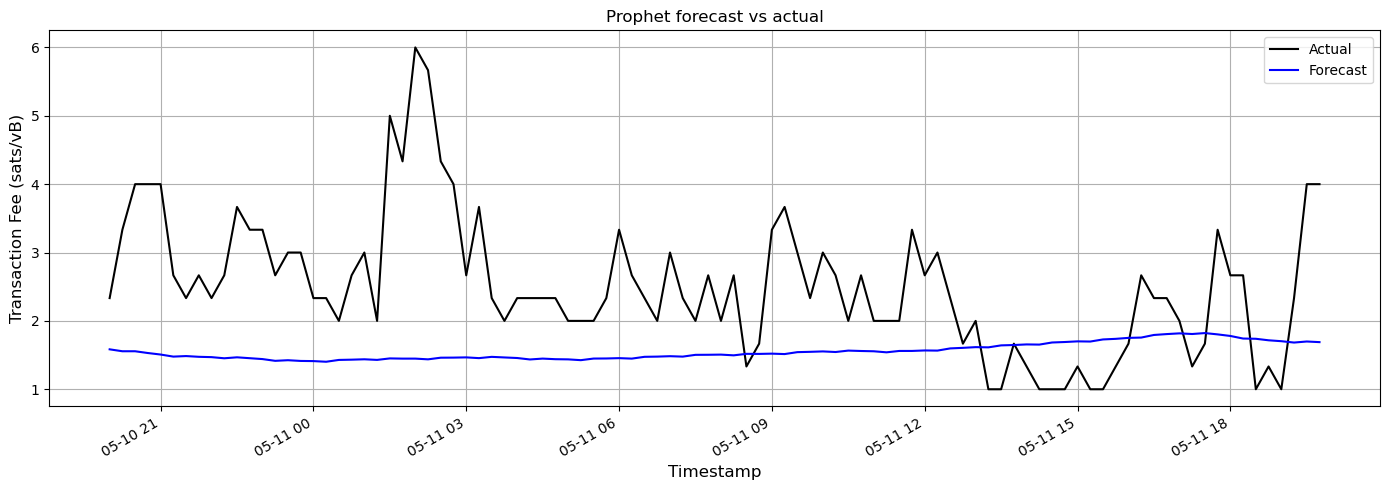

In [36]:
y_pred = forecast["yhat"].iloc[-96:]
forecast_prophet = pd.DataFrame(y_pred.values, columns=["y_pred"])
forecast_prophet["timestamp"] = y_test_new.reset_index()["timestamp"]  # assumes df_test has timestamps aligned
forecast_prophet["series_id"] = "recommended_fee_fastestFee"
forecast_prophet["y_true"] = y_test_new.values
plt.figure(figsize=(12, 5))
plot_series(forecast_prophet, sid = "recommended_fee_fastestFee")
plt.title("Prophet forecast vs actual")
plt.tight_layout()
plt.show()

In [37]:
prophet_result = eval_metrics(forecast_prophet["y_pred"], forecast_prophet["y_true"])
prophet_result

,value
custom_loss,2.8125
std_diff,0.8805
dev_error,0.7888
mae,1.1432
mape,0.4216
rmse,1.4289


### Why This Step Matters
- Multi-split evaluation simulates production performance under changing network states

- Reduces bias from a single time split and highlights week-over-week stability

- Increases confidence in the model’s behavior under different volatility regimes

## Set holidays

Prophet also supports manually setting holiday parameters. In this case, we found the best choice was to define holidays as the timestamps corresponding to the top 10% of the values. The log-transformed values increased by 25% percent in holidays compared to the baseline trend. 

In [38]:
model_holiday = create_model_new_holiday(y_train_new)
model_holiday.fit(df_prophet_new)
future = model_holiday.make_future_dataframe(periods=96, freq='15min')
forecast = model_holiday.predict(future)

14:35:55 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x500 with 0 Axes>

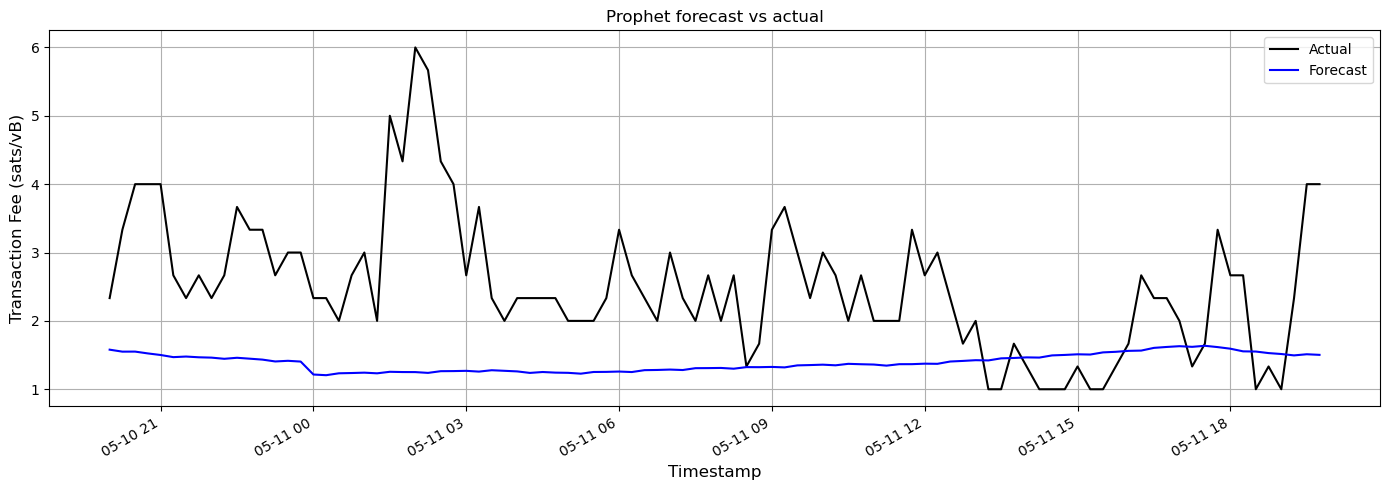

In [39]:
y_pred = forecast["yhat"].iloc[-96:]
forecast_prophet = pd.DataFrame(y_pred.values, columns=["y_pred"])
forecast_prophet["timestamp"] = y_test_new.reset_index()["timestamp"]  # assumes df_test has timestamps aligned
forecast_prophet["series_id"] = "recommended_fee_fastestFee"
forecast_prophet["y_true"] = y_test_new.values
plt.figure(figsize=(12, 5))
plot_series(forecast_prophet, sid = "recommended_fee_fastestFee")
plt.title("Prophet forecast vs actual")
plt.tight_layout()
plt.show()

In [40]:
prophet_result = eval_metrics(forecast_prophet["y_pred"], forecast_prophet["y_true"])
prophet_result

,value
custom_loss,2.8828
std_diff,0.8765
dev_error,0.7652
mae,1.2412
mape,0.4454
rmse,1.5327


### Why This Step Matters
- Enhances accuracy during spike periods by flagging known anomalies

- Helps Prophet adjust local forecasts in presence of demand shocks

- Provides interpretable structure to model volatility as event-driven

## The best model

Based on the results, model with manual set holiday parameters performs the best. Then we would use the model to train the whole data.

In [41]:
with open('../results/models/prophet_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load model
future = model.make_future_dataframe(periods=96, freq='15min')
forecast = model.predict(future)

<Figure size 1200x500 with 0 Axes>

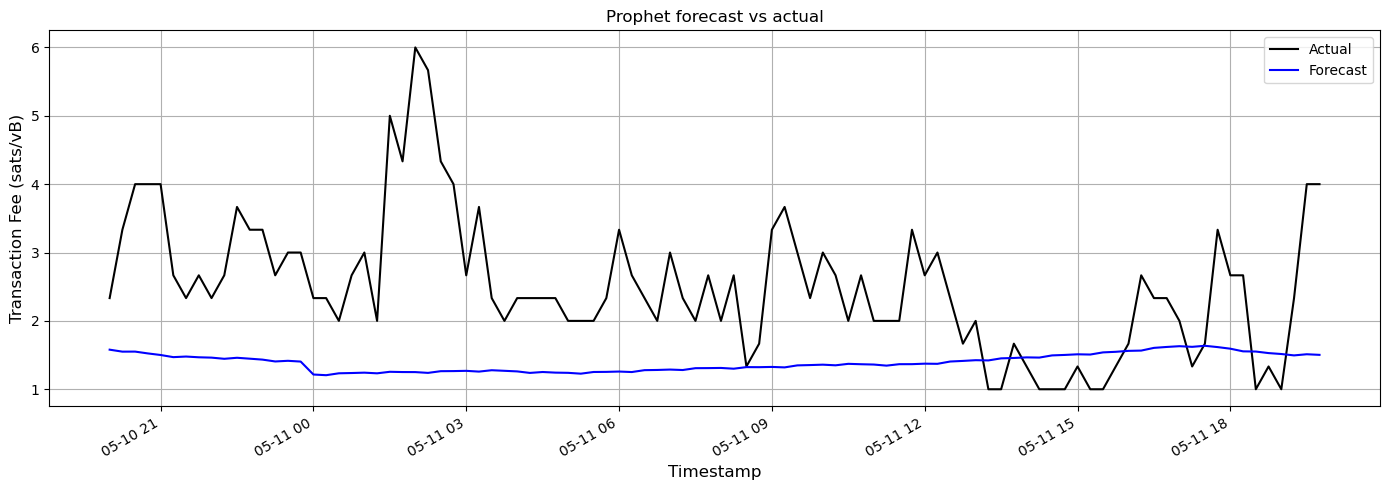

In [42]:
y_pred = forecast["yhat"].iloc[-96:]
forecast_prophet = pd.DataFrame(y_pred.values, columns=["y_pred"])
forecast_prophet["timestamp"] = y_test_new.reset_index()["timestamp"]  # assumes df_test has timestamps aligned
forecast_prophet["series_id"] = "recommended_fee_fastestFee"
forecast_prophet["y_true"] = y_test_new.values
plt.figure(figsize=(12, 5))
plot_series(forecast_prophet, sid = "recommended_fee_fastestFee")
plt.title("Prophet forecast vs actual")
plt.tight_layout()
plt.show()

In [43]:
prophet_result = eval_metrics(forecast_prophet["y_pred"], forecast_prophet["y_true"])
prophet_result

,value
custom_loss,2.8828
std_diff,0.8765
dev_error,0.7652
mae,1.2412
mape,0.4454
rmse,1.5327


### Why This Step Matters
- Provides the most stable configuration for operational forecasting

- Represents Prophet’s maximum potential under current assumptions

- Enables fair comparison against other models using consistent data window

## Conclusion

The performance is not as good as baseline. We should try other advanced models. Prophet underperforms compared to XGBoost and the global median baseline. While it captures seasonality and trend structure, it struggles with sudden spikes.

